### ANother code 

Train Images


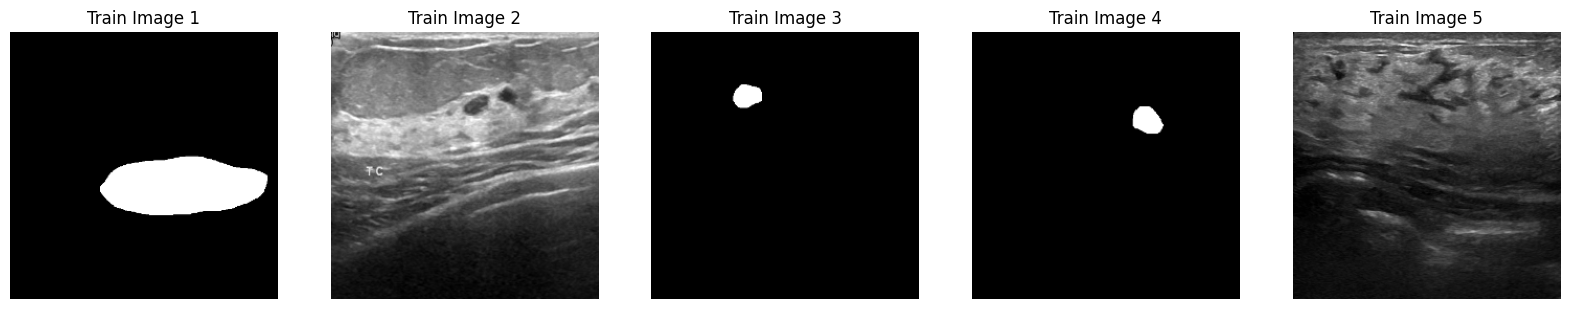

Validation Images


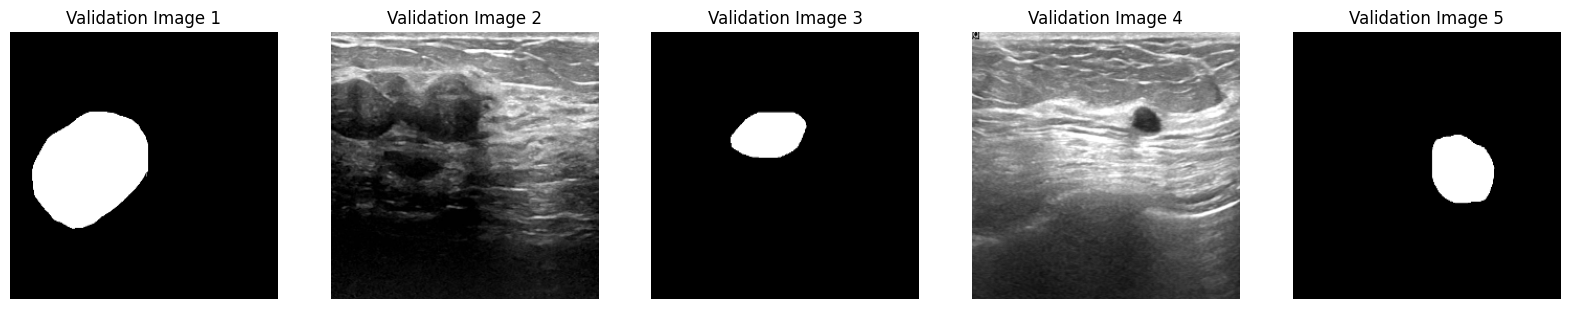

Test Images


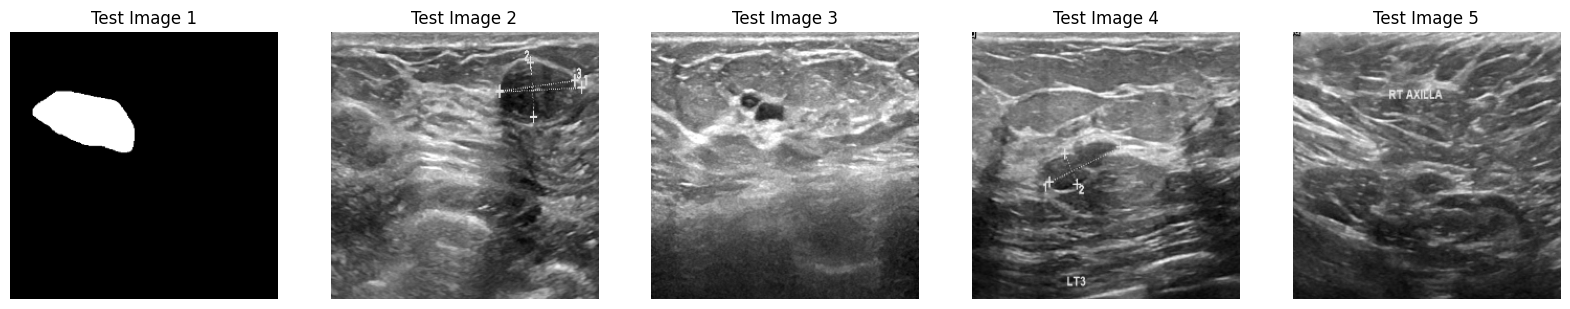

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 256, 256, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_29 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_28[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 32)         0         ['conv2d_29[0][0]']           
 g2D)                                                                                       

2024-08-05 17:49:11.122080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/35 [==============================] - 17s 278ms/step - loss: 30.2365 - accuracy: 0.4519 - val_loss: 26.1399 - val_accuracy: 0.4422
Epoch 2/50
35/35 [==============================] - 9s 264ms/step - loss: 22.8972 - accuracy: 0.4628 - val_loss: 19.8547 - val_accuracy: 0.4422
Epoch 3/50
35/35 [==============================] - 9s 264ms/step - loss: 17.4822 - accuracy: 0.4629 - val_loss: 15.1331 - val_accuracy: 0.4422
Epoch 4/50
35/35 [==============================] - 9s 263ms/step - loss: 13.3121 - accuracy: 0.4629 - val_loss: 11.5691 - val_accuracy: 0.4422
Epoch 5/50
35/35 [==============================] - 9s 263ms/step - loss: 10.2341 - accuracy: 0.4617 - val_loss: 8.8968 - val_accuracy: 0.4423
Epoch 6/50
35/35 [==============================] - 9s 263ms/step - loss: 7.9134 - accuracy: 0.4629 - val_loss: 6.9071 - val_accuracy: 0.4422
Epoch 7/50
35/35 [==============================] - 9s 264ms/step - loss: 6.1661 - accuracy: 0.4629 - val_loss: 5.4015 - val_accuracy: 0.4422
Epoch 8

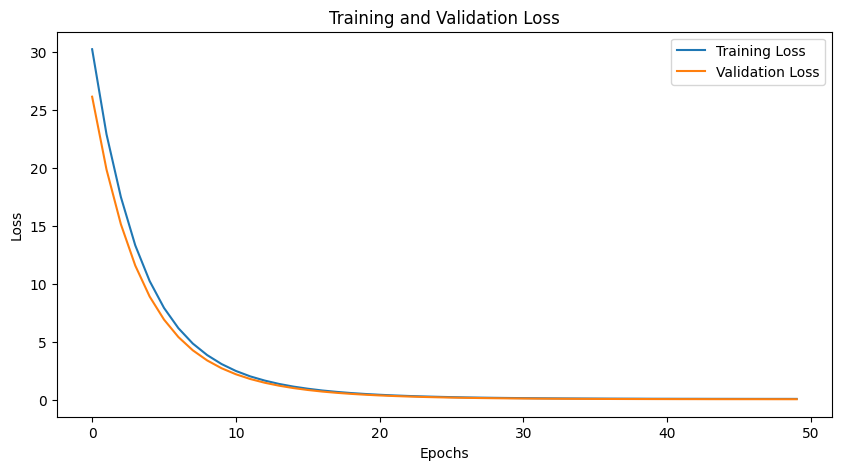

1/1 [==============================] - 0s 298ms/step


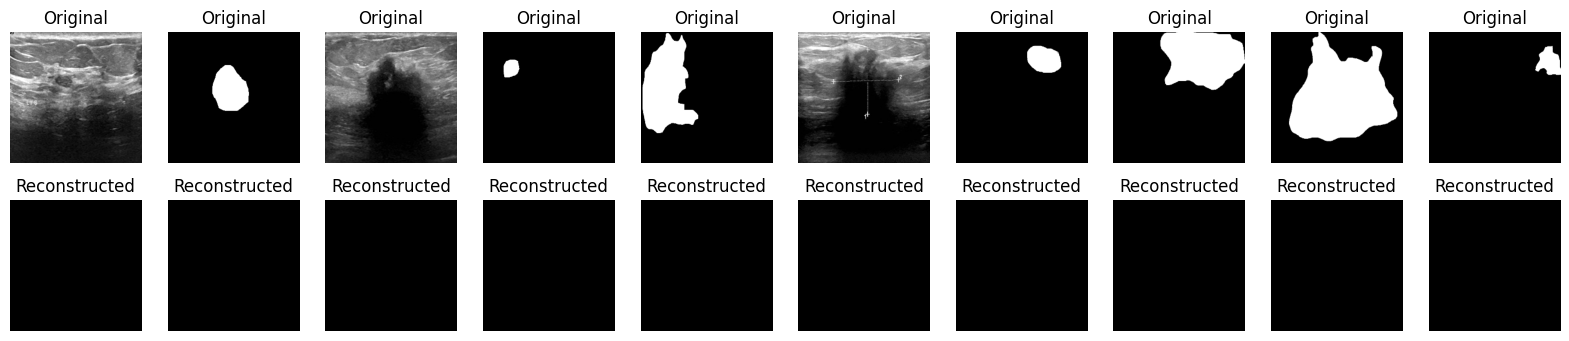

8/8 [==============================] - 1s 55ms/step - loss: 0.0386 - accuracy: 0.5174
Test Loss: 0.038558728992938995
Test Accuracy: 0.5173883438110352


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import cv2

# Define paths
base_dir = '/home/ubuntu/BCS/Breast_Cancer_Segmentation/Dataset_BUSI_with_GT'
subfolders = ['benign', 'malignant', 'normal']

# Function to load and filter images excluding those ending with masl.png
def load_images(folder_path):
    images = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png') and not file.endswith('masl.png'):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (256, 256))
                img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                images.append(img)
    return np.expand_dims(images, axis=-1)  # Add channel dimension

# Function to create datasets
def create_datasets(base_dir, subfolders):
    train_images, validation_images, test_images = [], [], []
    for folder in subfolders:
        folder_path = os.path.join(base_dir, folder)
        images = load_images(folder_path)
        split_1 = int(0.7 * len(images))
        split_2 = int(0.85 * len(images))
        train_images.extend(images[:split_1])
        validation_images.extend(images[split_1:split_2])
        test_images.extend(images[split_2:])
    return np.array(train_images), np.array(validation_images), np.array(test_images)

train_images, validation_images, test_images = create_datasets(base_dir, subfolders)

# Function to visualize images
def visualize_images(images, title, num_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"{title} {i + 1}")
        plt.axis('off')
    plt.show()

# Visualize loaded images
print("Train Images")
visualize_images(train_images, "Train Image")

print("Validation Images")
visualize_images(validation_images, "Validation Image")

print("Test Images")
visualize_images(test_images, "Test Image")

# Data augmentation and scaling
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Create augmented data generators
train_generator = train_datagen.flow(train_images, train_images, batch_size=32)
validation_generator = validation_datagen.flow(validation_images, validation_images, batch_size=32)
test_generator = test_datagen.flow(test_images, test_images, batch_size=32)

# Define U-Net Model with Regularization and Dropout for grayscale images
def unet_autoencoder(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(0.5)(pool1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    # Bottleneck
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool4)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv5)
    conv5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge6)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv6)

    up7 = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv7)

    up8 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv8)

    up9 = layers.Conv2D(32, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv10 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy'])

    return model

autoencoder = unet_autoencoder()
autoencoder.summary()

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the autoencoder with early stopping
history = autoencoder.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])

# Save the trained model
autoencoder.save('breast_cancer_autoencoder.h5')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Function to plot original and reconstructed images
def plot_reconstructed_images(original_images, reconstructed_images, n=10, threshold=0.5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed_image = reconstructed_images[i].squeeze()
        # Apply threshold to binarize the image
        reconstructed_image = (reconstructed_image > threshold).astype(np.uint8)
        plt.imshow(reconstructed_image, cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Get a batch of images from the test set
test_images, _ = next(iter(test_generator))
# Get the reconstructed images
reconstructed_images = autoencoder.predict(test_images)

# Ensure the reconstructed images are in the range [0, 1]
reconstructed_images = np.clip(reconstructed_images, 0, 1)

# Plot original and reconstructed images with cancer tissue highlighted
plot_reconstructed_images(test_images, reconstructed_images, n=10, threshold=0.5)

# Evaluate on the test set
test_loss, test_accuracy = autoencoder.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1/1 [==============================] - 0s 24ms/step


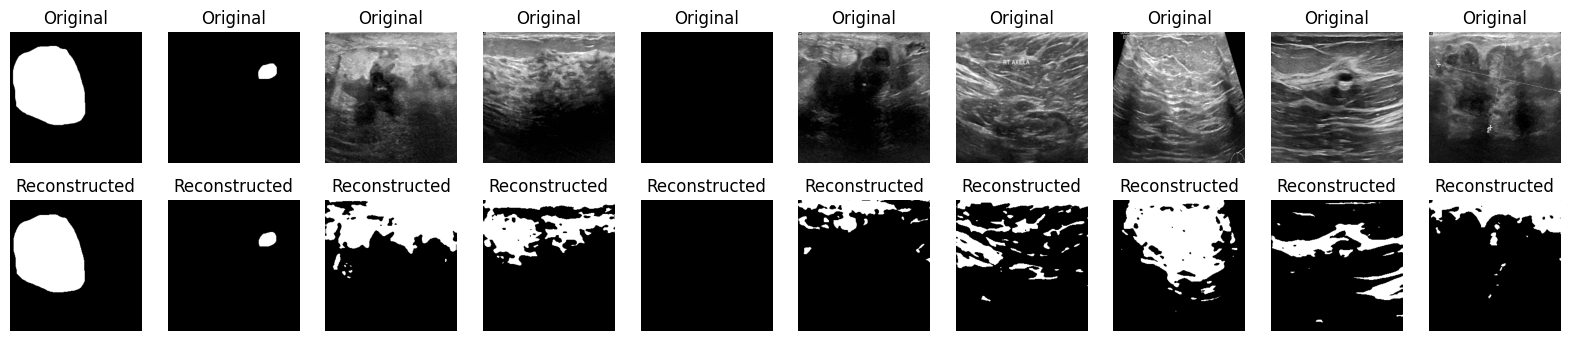

8/8 [==============================] - 0s 55ms/step - loss: 0.0386 - accuracy: 0.5174
Test Loss: 0.038558732718229294
Test Accuracy: 0.5173883438110352


In [26]:
# Function to plot original and reconstructed images
def plot_reconstructed_images(original_images, reconstructed_images, n=10, threshold=0.45):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed_image = reconstructed_images[i].squeeze()
        # Apply threshold to binarize the image
        reconstructed_image = (reconstructed_image > threshold).astype(np.uint8)
        plt.imshow(reconstructed_image, cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Get a batch of images from the test set
test_images, _ = next(iter(test_generator))
# Get the reconstructed images
reconstructed_images = autoencoder.predict(test_images)

# Ensure the reconstructed images are in the range [0, 1]
reconstructed_images = np.clip(reconstructed_images, 0, 1)

# Plot original and reconstructed images with cancer tissue highlighted
plot_reconstructed_images(test_images, reconstructed_images, n=10, threshold=0.45)

# Evaluate on the test set
test_loss, test_accuracy = autoencoder.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
